# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as fs
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

import datetime

import pandas as pd
import numpy as np
import seaborn as sns


from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json' 
df = spark.read.json(sparkify_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df_pandas=df.toPandas()
df_pandas.replace('', np.nan, inplace=True)
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
#check null records
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [6]:
df_null=df_pandas[df_pandas.userId.isnull()]
df_null.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
57,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,NaN
58,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,NaN
59,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,NaN
60,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,NaN
76,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,NaN


In [7]:
df_null['level'].unique()

array(['free', 'paid'], dtype=object)

In [8]:
df_null['method'].unique()

array(['GET', 'PUT'], dtype=object)

In [9]:
df_null['page'].unique()

array(['Home', 'Help', 'Login', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

In [10]:
df_null['auth'].unique()

array(['Logged Out', 'Guest'], dtype=object)

In [11]:
df_null['gender'].unique()

array([None], dtype=object)

After some investigation of the null values, it looks that all the missing useId cases are Guest or where users are logged out. This is also in line with the page values ('Register','Login' etc.) from those page values. So we can probabely safely drop those cases.

In [12]:
df_notnull = df_pandas[df_pandas.userId.notnull()]

In [13]:
#drop missing records with userId in Spark data 
df=df.dropna(how = "any", subset = ["userId", "sessionId"])

In [14]:
#double check
df_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null float64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 40.3+ MB


In [15]:
#Explore values for catergorical cols
df_notnull['gender'].unique()

array(['M', 'F'], dtype=object)

In [16]:
df_notnull['level'].unique()

array(['paid', 'free'], dtype=object)

In [17]:
df_notnull['method'].unique()

array(['PUT', 'GET'], dtype=object)

In [18]:
df_notnull['status'].unique()

array([200, 307, 404])

In [19]:
df_notnull['page'].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
df_notnull['userId'].nunique()

225

In [21]:
df_notnull['sessionId'].nunique()

2312

In this sample, we are looking at 225 users and 2,312 user actions.

In [22]:
#Define flags for churned users
flag_cancelation_event = fs.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds per user
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", fs.sum("churn").over(windowval))

[Text(0.5,1,'Count of Users by Gender')]

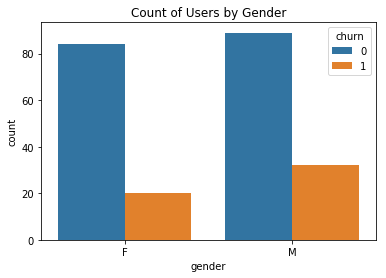

In [23]:
#plot by churn or not
sns.countplot(x = "gender", hue = "churn", data = df.select('userId','gender','churn').dropDuplicates().toPandas()).set(title = 'Count of Users by Gender')

[Text(0.5,1,'Count of Users by Service Level')]

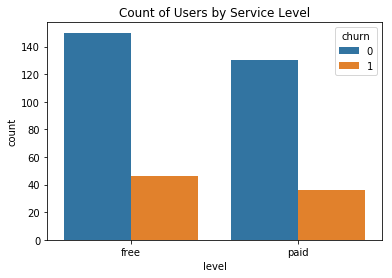

In [24]:
sns.countplot(x = "level", hue = "churn", data = df.select('userId','level','churn').dropDuplicates().toPandas()).set(title = 'Count of Users by Service Level')

[Text(0,0,'NextSong'),
 Text(0,0,'Thumbs Up'),
 Text(0,0,'Roll Advert'),
 Text(0,0,'Home'),
 Text(0,0,'Logout'),
 Text(0,0,'Add to Playlist'),
 Text(0,0,'Help'),
 Text(0,0,'Add Friend'),
 Text(0,0,'Thumbs Down'),
 Text(0,0,'Upgrade'),
 Text(0,0,'About'),
 Text(0,0,'Settings'),
 Text(0,0,'Submit Upgrade'),
 Text(0,0,'Downgrade'),
 Text(0,0,'Cancel'),
 Text(0,0,'Cancellation Confirmation'),
 Text(0,0,'Error'),
 Text(0,0,'Save Settings'),
 Text(0,0,'Submit Downgrade'),
 Text(0,0,'Login'),
 Text(0,0,'Register'),
 Text(0,0,'Submit Registration')]

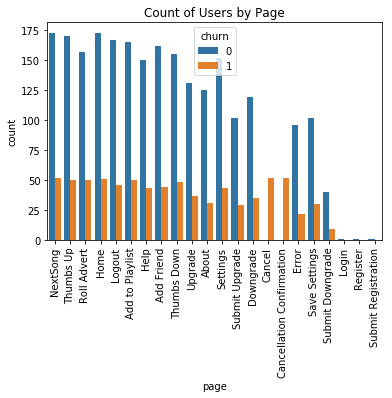

In [25]:
chart=sns.countplot(x = "page", hue='churn', data = df.select('userId','page','churn').dropDuplicates().toPandas())
chart.set(title = 'Count of Users by Page')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
#starting position
df_base=df.select('userId','churn','gender').dropDuplicates()

In [28]:
# add cleaner verion of time 
get_hour = fs.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = fs.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = fs.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = fs.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))

In [38]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1')

In [29]:
#Creat dummy variables

#Gender
gender_Male = fs.udf(lambda x: 1 if x == "M" else 0, IntegerType())
gender_Female = fs.udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_base =df_base.withColumn("gender_Male", gender_Male("gender"))
df_base =df_base.withColumn("gender_Female", gender_Female("gender"))
df_base =df_base.drop('gender')

In [30]:
#Service level
df_service=df.select('userId', 'level').dropDuplicates()
df_service=df_service.withColumn('level_count', fs.count('userId').over(windowval))
df_service.show()

+------+-----+-----------+
|userId|level|level_count|
+------+-----+-----------+
|100010| free|          1|
|200002| free|          2|
|200002| paid|          2|
|   125| free|          1|
|   124| paid|          1|
|    51| paid|          1|
|     7| free|          1|
|    15| paid|          1|
|    54| free|          2|
|    54| paid|          2|
|   155| free|          2|
|   155| paid|          2|
|100014| paid|          1|
|   132| free|          2|
|   132| paid|          2|
|   154| free|          1|
|   101| free|          2|
|   101| paid|          2|
|    11| free|          2|
|    11| paid|          2|
+------+-----+-----------+
only showing top 20 rows



In [31]:
free_flag=fs.udf(lambda x,y: 1 if x == "free" and y==1 else 0, IntegerType())
paid_flag=fs.udf(lambda x,y: 1 if x == "paid" and y==1 else 0, IntegerType())
free_paid_flag=fs.udf(lambda x: 1 if x==2 else 0, IntegerType())

df_service = df_service.withColumn('free_flag', free_flag('level','level_count'))
df_service = df_service.withColumn('paid_flag', paid_flag('level','level_count'))
df_service = df_service.withColumn('free_paid_flag', free_paid_flag('level_count'))
df_service.drop('level','level_count').collect()
df_service = df_service.select('userId','free_flag','paid_flag','free_paid_flag').dropDuplicates()

In [32]:
df_service.show()

+------+---------+---------+--------------+
|userId|free_flag|paid_flag|free_paid_flag|
+------+---------+---------+--------------+
|   114|        0|        0|             1|
|     4|        0|        0|             1|
|    95|        0|        0|             1|
|300021|        0|        0|             1|
|100002|        0|        1|             0|
|     3|        0|        1|             0|
|      |        0|        0|             1|
|    37|        0|        0|             1|
|300008|        0|        1|             0|
|300003|        1|        0|             0|
|    73|        0|        0|             1|
|    80|        1|        0|             0|
|300013|        0|        1|             0|
|    84|        1|        0|             0|
|    93|        0|        0|             1|
|   133|        1|        0|             0|
|    43|        1|        0|             0|
|    40|        0|        0|             1|
|    44|        0|        0|             1|
|100012|        0|        0|    

In [33]:
#1.Average Number of songs per session for each user
df_Song_perSession = df.filter(df.page == 'NextSong').groupBy('userId', 'sessionId').count()
df_Song_perSession = df_Song_perSession.groupBy('userId').agg(fs.avg('count').alias('avg_songs_persession'))
df_Song_perSession = df_Song_perSession.na.fill(0)
df_Song_perSession.show(5)

+------+--------------------+
|userId|avg_songs_persession|
+------+--------------------+
|100010|  39.285714285714285|
|200002|                64.5|
|   125|                 8.0|
|    51|               211.1|
|   124|  145.67857142857142|
+------+--------------------+
only showing top 5 rows



In [34]:
#2.Number of sessions by User
df_session_count = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
df_session_count = df_session_count.withColumnRenamed("count", "num_session")
df_session_count.show(5)

+------+-----------+
|userId|num_session|
+------+-----------+
|100010|          7|
|200002|          6|
|   125|          1|
|    51|         10|
|   124|         29|
+------+-----------+
only showing top 5 rows



In [39]:
#3.Avg numbr of days logged in per month
df_ts = df.filter(df.auth=='Logged In').select('userId', 'ts', 'day','month').dropDuplicates()

df_ts_count=df_ts.select('userId','day','month').dropDuplicates()
df_ts_count=df_ts_count.groupby('userId','month').count()
df_ts_count=df_ts_count.groupBy('userId').agg(fs.avg('count').alias('avg_days_login_permonth'))

In [40]:
df_ts_count.show(5)

+------+-----------------------+
|userId|avg_days_login_permonth|
+------+-----------------------+
|200002|                    3.5|
|100010|                    3.5|
|   125|                    1.0|
|    51|                   13.0|
|     7|                    4.0|
+------+-----------------------+
only showing top 5 rows



In [41]:
#4. frequency of use of page actions per month
df_page=df.select('userId','page','month')

df_thumbsdown=df_page.filter(df.page=='Thumbs Down').groupby('userId','month').count()
df_thumbsdown=df_thumbsdown.groupBy('userId').agg(fs.avg('count').alias('avg_thumbsdown_permonth'))

In [42]:
df_thumbsdown.show(5)

+------+-----------------------+
|userId|avg_thumbsdown_permonth|
+------+-----------------------+
|200002|                    6.0|
|100010|                    2.5|
|    51|                   21.0|
|   124|                   20.5|
|     7|                    1.0|
+------+-----------------------+
only showing top 5 rows



In [43]:
df_thumbsup=df_page.filter(df.page=='Thumbs Up').groupby('userId','month').count()
df_thumbsup=df_thumbsup.groupBy('userId').agg(fs.avg('count').alias('avg_thumbsup_permonth'))

In [44]:
df_playlist=df_page.filter(df.page=='Add to Playlist').groupby('userId','month').count()
df_playlist=df_playlist.groupBy('userId').agg(fs.avg('count').alias('avg_playlist_permonth'))

df_friend=df_page.filter(df.page=='Add Friend').groupby('userId','month').count()
df_friend=df_friend.groupBy('userId').agg(fs.avg('count').alias('avg_addfriend_permonth'))

df_rollad=df_page.filter(df.page=='Roll Advert').groupby('userId','month').count()
df_rollad=df_rollad.groupBy('userId').agg(fs.avg('count').alias('avg_rollad_permonth'))

df_help=df_page.filter(df.page=='Help').groupby('userId','month').count()
df_help=df_help.groupBy('userId').agg(fs.avg('count').alias('avg_help_permonth'))

df_error=df_page.filter(df.page=='Error').groupby('userId','month').count()
df_error=df_error.groupBy('userId').agg(fs.avg('count').alias('avg_error_permonth'))

In [45]:
#5 Days since registration
user_max_ts = df.groupby("userId").max("ts").sort("userId")
user_reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [46]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



In [47]:
#6 Session Duration
session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
df_session= session_start.join(session_end,['userId', 'sessionId'])
df_session = df_session.select('userId', 'sessionId', ((df_session.end-df_session.start/(1000*60*60)).alias('session_hours')))
df_session =df_session.groupby('userId').agg(fs.avg('session_hours').alias('avg_session_hour'))

In [48]:
df_session.show(5)

+------+--------------------+
|userId|    avg_session_hour|
+------+--------------------+
|100010|1.540624836479683...|
|200002|1.539845829102702E12|
|   125|1.539318490411904...|
|    51|1.539226934851383E12|
|   124|1.541082741310301...|
+------+--------------------+
only showing top 5 rows



Collect All

In [49]:
# put all the features dataframe into a list
features_list = []
features_list.append(df_service)
features_list.append(df_Song_perSession)
features_list.append(df_session_count)
features_list.append(df_ts_count)
features_list.append(df_thumbsdown)
features_list.append(df_thumbsup)
features_list.append(df_playlist)
features_list.append(df_friend)
features_list.append(df_rollad)
features_list.append(df_help)
features_list.append(df_error)
features_list.append(user_reg_days)
features_list.append(df_session)

In [50]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [51]:
df_final=df_base

for feature in features_list:
    df_final = features_merge(df_final, feature)

In [52]:
df_final.show(5)

+------+-----+-----------+-------------+---------+---------+--------------+--------------------+-----------+-----------------------+-----------------------+---------------------+---------------------+----------------------+-------------------+-----------------+------------------+------------------+--------------------+
|userId|churn|gender_Male|gender_Female|free_flag|paid_flag|free_paid_flag|avg_songs_persession|num_session|avg_days_login_permonth|avg_thumbsdown_permonth|avg_thumbsup_permonth|avg_playlist_permonth|avg_addfriend_permonth|avg_rollad_permonth|avg_help_permonth|avg_error_permonth|            regDay|    avg_session_hour|
+------+-----+-----------+-------------+---------+---------+--------------+--------------------+-----------+-----------------------+-----------------------+---------------------+---------------------+----------------------+-------------------+-----------------+------------------+------------------+--------------------+
|100010|    0|          0|           

In [56]:
# Saving as SPARK format
df_final.write.save('saved_final_user_dataset.CSV', format='csv', header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [80]:
#loading data 
df_final = spark.read.csv('saved_final_user_dataset.CSV', header = True)

In [81]:
df_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender_Male: string (nullable = true)
 |-- gender_Female: string (nullable = true)
 |-- free_flag: string (nullable = true)
 |-- paid_flag: string (nullable = true)
 |-- free_paid_flag: string (nullable = true)
 |-- avg_songs_persession: string (nullable = true)
 |-- num_session: string (nullable = true)
 |-- avg_days_login_permonth: string (nullable = true)
 |-- avg_thumbsdown_permonth: string (nullable = true)
 |-- avg_thumbsup_permonth: string (nullable = true)
 |-- avg_playlist_permonth: string (nullable = true)
 |-- avg_addfriend_permonth: string (nullable = true)
 |-- avg_rollad_permonth: string (nullable = true)
 |-- avg_help_permonth: string (nullable = true)
 |-- avg_error_permonth: string (nullable = true)
 |-- regDay: string (nullable = true)
 |-- avg_session_hour: string (nullable = true)



In [82]:
#Convert String to Numeric
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "_Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [88]:
df_final = df_final.na.fill(0)

In [160]:
features_labels = df_final.columns[2:]
features_labels

['gender_Male_Num',
 'gender_Female_Num',
 'free_flag_Num',
 'paid_flag_Num',
 'free_paid_flag_Num',
 'avg_songs_persession_Num',
 'num_session_Num',
 'avg_days_login_permonth_Num',
 'avg_thumbsdown_permonth_Num',
 'avg_thumbsup_permonth_Num',
 'avg_playlist_permonth_Num',
 'avg_addfriend_permonth_Num',
 'avg_rollad_permonth_Num',
 'avg_help_permonth_Num',
 'avg_error_permonth_Num',
 'regDay_Num',
 'avg_session_hour_Num']

In [94]:
# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=df_final.columns[2:], outputCol='features')
# Apply the vectorization on the dataset
input_data = features_vector.transform(df_final)

In [95]:
input_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn_Num: float (nullable = false)
 |-- gender_Male_Num: float (nullable = false)
 |-- gender_Female_Num: float (nullable = false)
 |-- free_flag_Num: float (nullable = false)
 |-- paid_flag_Num: float (nullable = false)
 |-- free_paid_flag_Num: float (nullable = false)
 |-- avg_songs_persession_Num: float (nullable = false)
 |-- num_session_Num: float (nullable = false)
 |-- avg_days_login_permonth_Num: float (nullable = false)
 |-- avg_thumbsdown_permonth_Num: float (nullable = false)
 |-- avg_thumbsup_permonth_Num: float (nullable = false)
 |-- avg_playlist_permonth_Num: float (nullable = false)
 |-- avg_addfriend_permonth_Num: float (nullable = false)
 |-- avg_rollad_permonth_Num: float (nullable = false)
 |-- avg_help_permonth_Num: float (nullable = false)
 |-- avg_error_permonth_Num: float (nullable = false)
 |-- regDay_Num: float (nullable = false)
 |-- avg_session_hour_Num: float (nullable = false)
 |-- features: vector (nullable

In [97]:
#Transform features
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [99]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn_Num.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [138]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.8, 0.2], seed=78)
#train.show(3), test.show(3)

In [109]:
#Evaluator
evaluator_f1=MulticlassClassificationEvaluator(metricName="f1")

#### Logistic Regression 

In [102]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

In [116]:
result_lr=cvModel_lr.transform(train)

In [118]:
print("Accuracy for Logistic Regression Model is: ", result_lr.filter(result_lr.label == result_lr.prediction).count()/ result_lr.count())
print("F1 for Logistic Regression Model is: ", evaluator_f1.evaluate(result_lr))

Accuracy for Logistic Regression Model is:  0.9340659340659341
F1 for Logistic Regression Model is:  0.9315114709851551


#### Decision Tree

In [140]:
dtc = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()
crossval_dtc = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dtc = crossval_dts.fit(train)

In [141]:
result_dtc=cvModel_dtc.transform(train)

In [142]:
print("Accuracy for Decision Tree Model is: ", result_dtc.filter(result_dtc.label == result_dtc.prediction).count()/ result_dtc.count())
print("F1 for Decision Tree Model is: ", evaluator_f1.evaluate(result_dtc))

Accuracy for Decision Tree Model is:  0.989010989010989
F1 for Decision Tree Model is:  0.9890992393920285


#### GBTClassifier

In [147]:
gbt=GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[3, 10]) \
    .addGrid(gbt.maxBins ,[10, 5]) \
    .addGrid(gbt.maxIter ,[20, 5]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt, 
                     estimatorParamMaps=paramGrid,
                     evaluator=MulticlassClassificationEvaluator(),
                     numFolds=3)

cvModel_gbt=crossval_gbt.fit(train)

In [148]:
result_gbt=cvModel_gbt.transform(train)

In [150]:
print("Accuracy for GBT Model is: ", result_gbt.filter(result_gbt.label == result_gbt.prediction).count()/ result_gbt.count())
print("F1 for GBT Tree Model is: ", evaluator_f1.evaluate(result_gbt))

Accuracy for GBT Model is:  0.9560439560439561
F1 for GBT Tree Model is:  0.9567244349853046


### Validation on the test set

In [151]:
#Logistic Regression 
result_test_lr=cvModel_lr.transform(test)
print("Accuracy for Decision Tree Model is: ", result_test_lr.filter(result_test_lr.label == result_test_lr.prediction).count()/ result_test_lr.count())
print("F1 for Decision Tree Model is: ", evaluator_f1.evaluate(result_test_lr))

Accuracy for Decision Tree Model is:  0.7272727272727273
F1 for Decision Tree Model is:  0.67988767988768


In [152]:
#Decision Tree
result_test_dtc=cvModel_dtc.transform(test)
print("Accuracy for Decision Tree Model is: ", result_test_dtc.filter(result_test_dtc.label == result_test_dtc.prediction).count()/ result_test_dtc.count())
print("F1 for Decision Tree Model is: ", evaluator_f1.evaluate(result_test_dtc))

Accuracy for Decision Tree Model is:  0.75
F1 for Decision Tree Model is:  0.75408670931059


In [154]:
#GBTClassifier
result_test_gbt=cvModel_gbt.transform(test)
print("Accuracy for Decision Tree Model is: ", result_test_gbt.filter(result_test_gbt.label == result_test_gbt.prediction).count()/ result_test_gbt.count())
print("F1 for Decision Tree Model is: ", evaluator_f1.evaluate(result_test_gbt))

Accuracy for Decision Tree Model is:  0.75
F1 for Decision Tree Model is:  0.75408670931059


Feature Importance

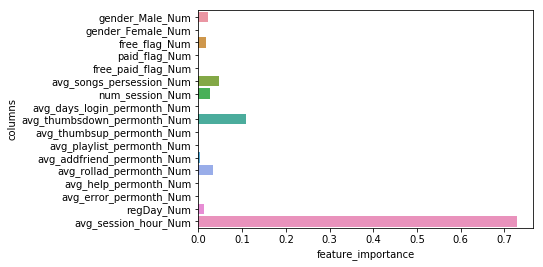

In [163]:
feature_importances = cvModel_dtc.bestModel.featureImportances.toArray()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': features_labels})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

All of the three machine learning models performed well in predicting those customers' who will most probably end in unsubscribing. By comparing the accuray and F1 scores on both train and test datasets, the Decision Tree Classifier model appears to be the best one. The average hour per session is the most important feature in predicting unsubscribing activity which contributes overwhelmingly 70%.

In [170]:
cvModel_dtc.save('DecisionTree.model')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.